<a href="https://colab.research.google.com/github/Ireneyou33/Model-Comparison-and-Forecasting-on-COVID-19/blob/master/Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
# %run functions.ipynb
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout
import datetime as dt
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras import Sequential
from keras.models import load_model
from keras.models import model_from_json
from datetime import datetime, timedelta

# Get the world class dataframe
def worldclass_dataframe(dataframe):
    date=dataframe.columns[4:]
    for i in range(len(date)):
        date.values[i]=pd.to_datetime(date.values[i], format="%m/%d/%y")
    world=dataframe.sum(axis=0, skipna=True)
    worldclass=world.iloc[3:,]
    arr=np.array(worldclass)
    new_df=pd.DataFrame([arr],columns=date)
    return new_df

def sum_regioncase(dataframe, region, region_level="country"):
    # region: county, region or outside China
    if region_level=="country":
        df_return=dataframe[dataframe["Country/Region"]==region].iloc[:,4:]
    elif region_level=="province":
        df_return=dataframe[dataframe["Province/State"]==region].iloc[:,4:]
    else:
        df_return=dataframe[dataframe["Country/Region"]!=region].iloc[:,4:]
    reg=df_return.sum(axis=0, skipna=True)
    arr=np.array(reg)
    date=df_return.columns
    for i in range(len(date)):
        date.values[i]=pd.to_datetime(date.values[i], format="%m/%d/%y")
    new_df=pd.DataFrame([arr],columns=date)
    return new_df, arr, date

def train_test(data, split_index):
    trainset=data.iloc[:, :split_index]
    testset=data.iloc[:, split_index:]
    return trainset, testset

def WindowSlider(data, w=1, r=1):
  #w: window size
  #r: response size

    cols=len(list(data))
    l=cols-(w+r)+1
    df = pd.DataFrame(np.zeros(shape=(l, w+w+2*r)))

    for m in range(l):
        slices=np.array([])
        delta_t=[]
        num_confirm=[]

        for i in range(w):
            i+=m
            delta=data.columns[i]-start_date
            delta=delta.floor('d').days
            delta_t.append(delta)
            num_confirm.append(data.iloc[0,i])

        y_delta=data.columns[m+w+r-1]-start_date
        y_delta=y_delta.floor('d').days
        y_delta=np.array(y_delta).reshape(1,)
        y=data.iloc[0,m+w+r-1]
        y=np.array(y).reshape(1,)

        slices=np.concatenate((slices, delta_t, num_confirm))
        slices=np.concatenate((slices, y_delta, y))

        df.iloc[m,:]=slices
    return df

def get_colnames(data, w=1, r=1):
    delta_names=[]
    x_names=[]
    for i in range(w):
        delta_names.append('∆t' + ('(%d)' % i))
        x_names.append('x'+ ('%d' % i))
    col_names=delta_names+x_names
    l=w+r-1
    col_names.append('∆t' + ('(%d)' % l))
    col_names.append('y')
    return col_names

def daily_bar_plot(dataframe, title, c=None):
    daily_df = dataframe.copy()
    length=dataframe.shape[1]
    for i in range(length-1):
        daily_df.iloc[0,i+1]=dataframe.iloc[0,i+1]-dataframe.iloc[0,i]
    daily_df.T.plot.bar(title=title, figsize=(25,10), legend=False, color=c)
    return daily_df

def barh_plot(dataframe, title, country=True, c=None):
    df=dataframe.iloc[:,[1,-1]]
    if country:
        sum_region = df.groupby(['Country/Region']).sum()
    else:
        print("Not country level")
    sum_region.columns=["date"]
    sum_region=sum_region.sort_values("date",ascending=False)
    new_df=sum_region.head(n=20)
    ax = new_df.plot.barh(color=c)
    ax.set_title(title)
    return new_df

def pie_plot(dataframe, stage, title, inplace=False):
    # stage = "Confirmed", "Deaths", "Recovered"
    dataframe2=dataframe.copy()
    dataframe2.reset_index(inplace=inplace)
    dataframe2.columns=["Country",stage]
    region=np.array(dataframe2.index.values)
    values=np.array(dataframe2.iloc[:,0])
    if stage == "Confirmed":
        fig = px.pie(dataframe2, names= 'Country', values=stage,title=title, color_discrete_sequence=px.colors.sequential.Blues)
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
    elif stage == "Deaths":
        fig = px.pie(dataframe2, names= 'Country', values=stage,title=title, color_discrete_sequence=px.colors.sequential.RdBu)
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
    elif stage == "Recovered":
        fig = px.pie(dataframe2, names= 'Country', values=stage,title=title, color_discrete_sequence=px.colors.sequential.Greens)
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
    else:
        print("Oooops Undefined Stage")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_conf=pd.read_csv("/content/drive/My Drive/ST494/project/Confirmed.csv")
df_death=pd.read_csv("/content/drive/My Drive/ST494/project/Deaths.csv")
df_recover=pd.read_csv("/content/drive/My Drive/ST494/project/Recovered.csv")

In [ ]:
df_conf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330,2402
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186,189,197,212,212,259,267


## Worldwide Spreading Map

In [ ]:
# !pip install folium

In [ ]:
import folium

In [ ]:
# World wide

m = folium.Map(location=[0, 0], tiles='cartodbpositron', zoom_start=2)

for i in range(0, len(df_conf)):
    folium.Circle(color='crimson',
        location=[df_conf.iloc[i]['Lat'], 
        df_conf.iloc[i]['Long']], 
        radius=float(df_conf.iloc[i][-1]),
        fill=True, fill_color='crimson').add_to(m)
display(m)

## Daily

### Worldclass

In [ ]:
df_worldclass=worldclass_dataframe(df_conf)
death_worldclass = worldclass_dataframe(df_death)
recover_worldclass=worldclass_dataframe(df_recover)

In [ ]:
df_worldclass

,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,...,2020-06-19 00:00:00,2020-06-20 00:00:00,2020-06-21 00:00:00,2020-06-22 00:00:00,2020-06-23 00:00:00,2020-06-24 00:00:00,2020-06-25 00:00:00,2020-06-26 00:00:00,2020-06-27 00:00:00,2020-06-28 00:00:00
0,555.0,654.0,941.0,1434.0,2118.0,2927.0,5578.0,6166.0,8234.0,9927.0,...,8670951.0,8829814.0,8961235.0,9099271.0,9264657.0,9432072.0,9610551.0,9802294.0,9980257.0,10145791.0


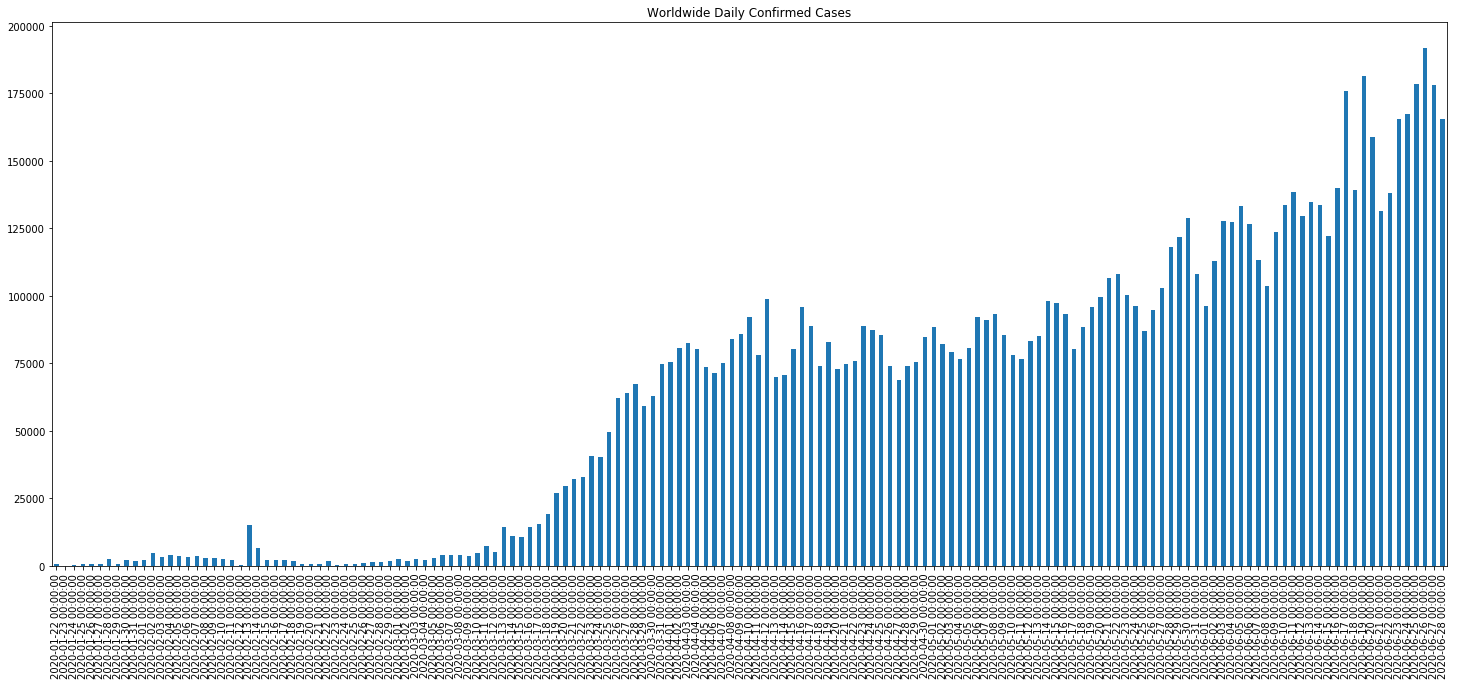

In [ ]:
world_conf_daily=daily_bar_plot(df_worldclass, title="Worldwide Daily Confirmed Cases")

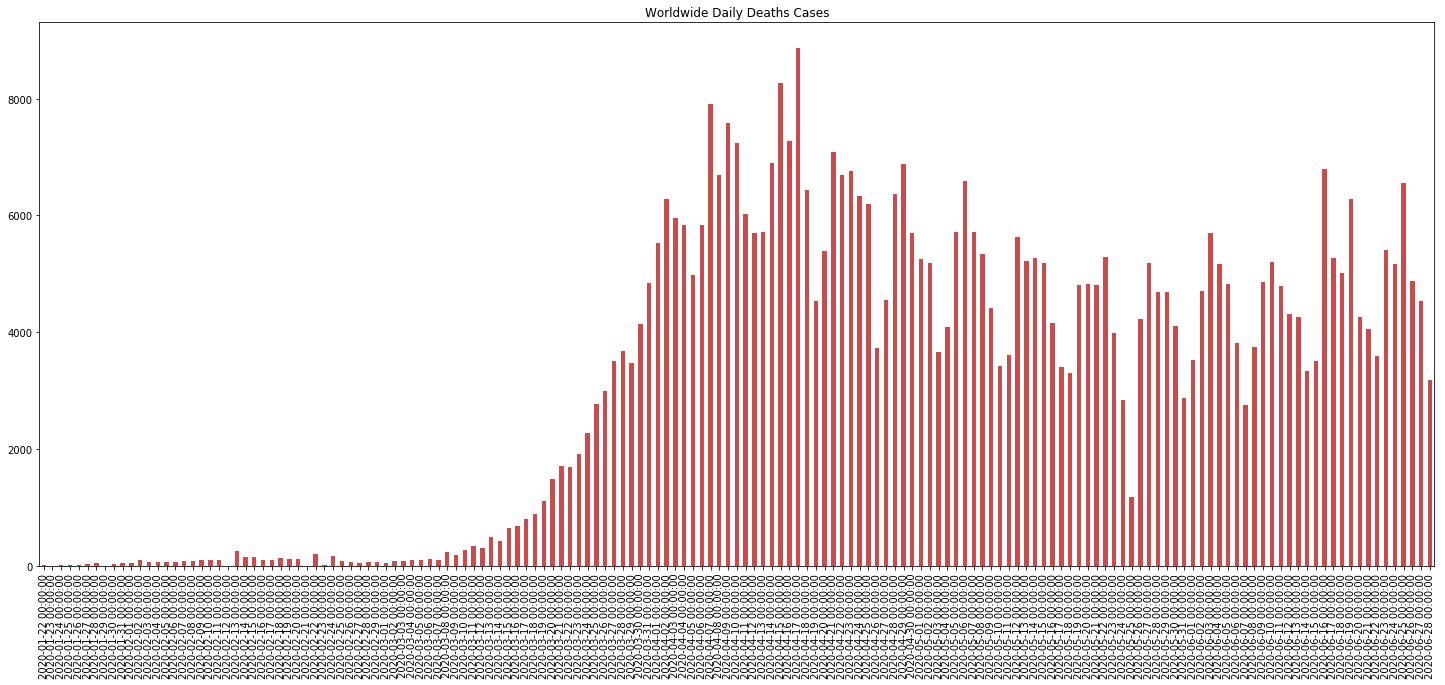

In [ ]:
world_death_daily=daily_bar_plot(death_worldclass, title="Worldwide Daily Deaths Cases",c=(0.7,0,0,0.7))

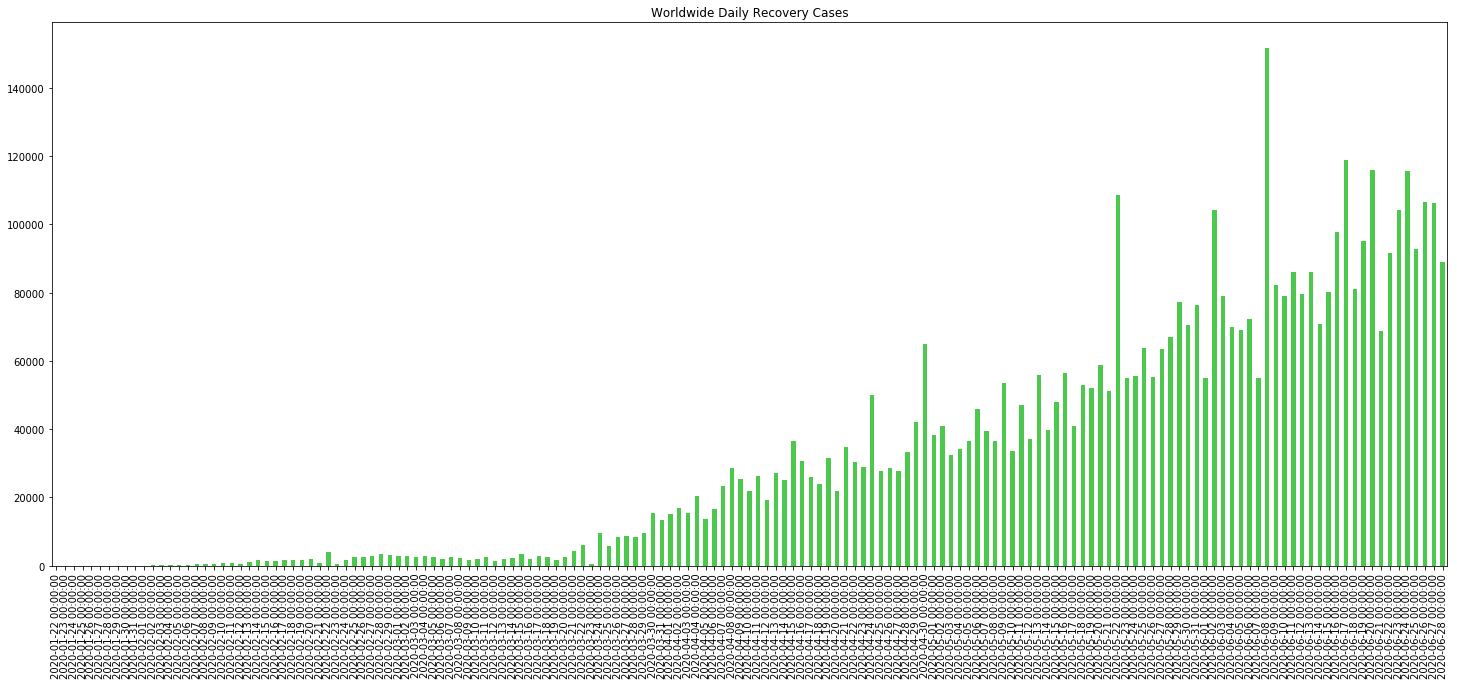

In [ ]:
world_rec_daily=daily_bar_plot(recover_worldclass, title="Worldwide Daily Recovery Cases",c=(0,0.7,0,0.7))

In [ ]:
world_daily=pd.concat([world_conf_daily, world_death_daily, world_rec_daily], axis= 0)
world_daily.index=pd.Series(["Confirmed", "Death", "Recover"])
world_daily

,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,...,2020-06-19 00:00:00,2020-06-20 00:00:00,2020-06-21 00:00:00,2020-06-22 00:00:00,2020-06-23 00:00:00,2020-06-24 00:00:00,2020-06-25 00:00:00,2020-06-26 00:00:00,2020-06-27 00:00:00,2020-06-28 00:00:00
Confirmed,555.0,99.0,287.0,493.0,684.0,809.0,2651.0,588.0,2068.0,1693.0,...,181347.0,158863.0,131421.0,138036.0,165386.0,167415.0,178479.0,191743.0,177963.0,165534.0
Death,17.0,1.0,8.0,16.0,14.0,26.0,49.0,2.0,38.0,42.0,...,6289.0,4254.0,4061.0,3588.0,5416.0,5171.0,6554.0,4869.0,4529.0,3183.0
Recover,28.0,2.0,6.0,3.0,13.0,9.0,46.0,19.0,17.0,79.0,...,95008.0,115825.0,68696.0,91705.0,104058.0,115727.0,92803.0,106636.0,106307.0,89035.0


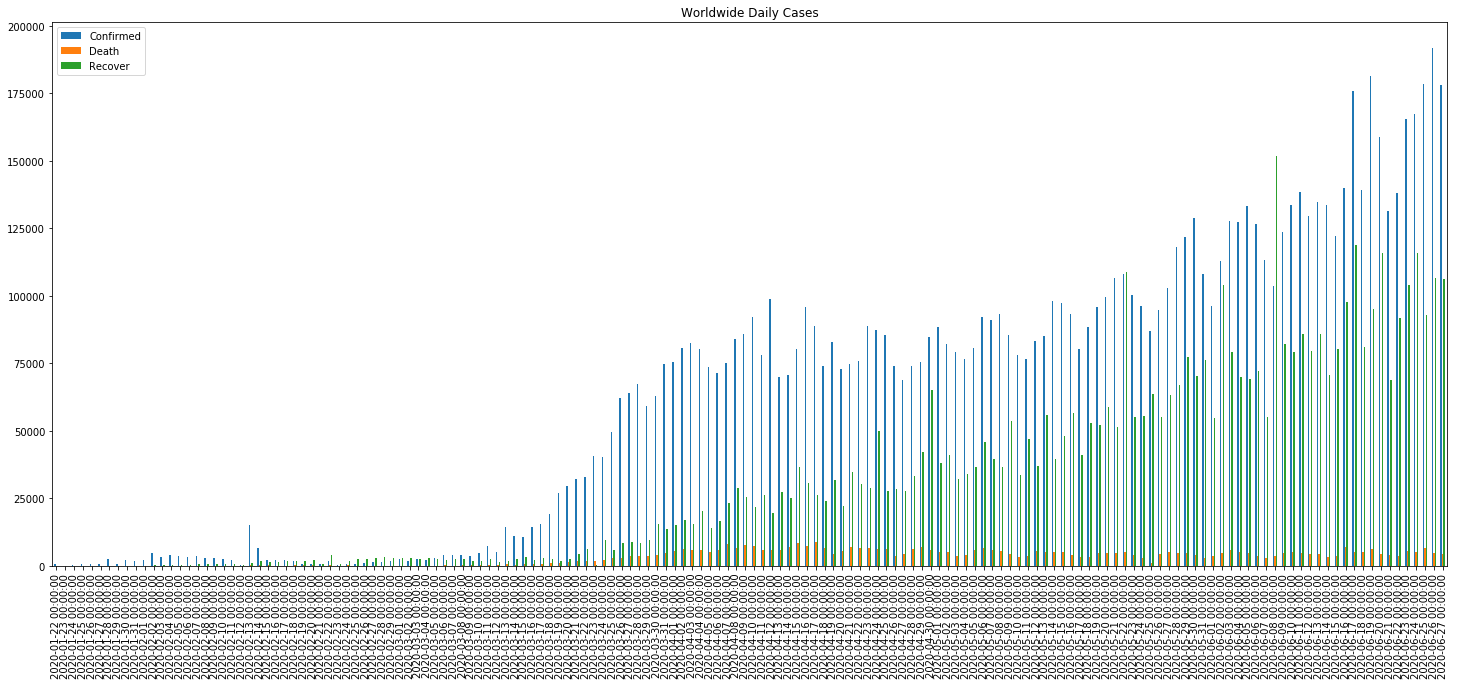

In [ ]:
world_daily2=world_daily.iloc[:,:-1]
world_daily2.T.plot.bar(title="Worldwide Daily Cases", figsize=(25,10), legend=True)

### Canada

In [ ]:
df_canada=df_conf[df_conf["Country/Region"]=="Canada"]
df_canada=df_canada.drop(df_canada.index[[11]]) # Drop a doesn't exist province
df_canada, _, _ = sum_regioncase(df_conf, "Canada", region_level="country")
df_canada

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28
0,0,0,0,0,1,1,2,2,2,4,4,4,4,4,5,5,7,7,7,7,7,7,7,7,7,7,8,8,8,8,9,9,9,10,11,11,13,14,20,24,...,81575,82742,83947,85151,86106,87119,88090,88989,89976,90909,91681,92479,93288,93960,94641,95269,95947,96475,97178,97779,98241,98720,99159,99595,100043,100404,100763,101087,101491,101877,102314,102762,103078,103418,103767,104087,104463,104629,104878,105193


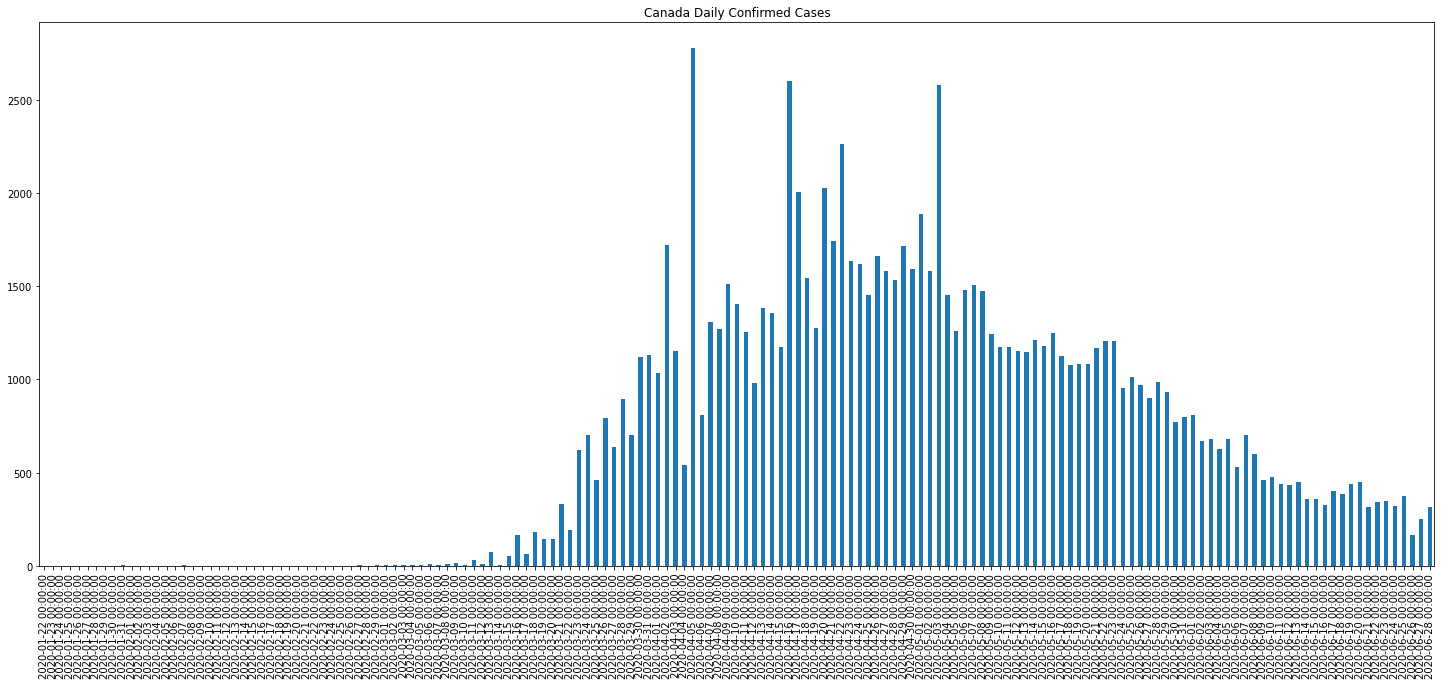

In [ ]:
can_conf_daily=daily_bar_plot(df_canada, title="Canada Daily Confirmed Cases")

In [ ]:
can_conf_daily

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28
0,0,0,0,0,1,0,1,0,0,2,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,2,1,6,4,...,1082,1167,1205,1204,955,1013,971,899,987,933,772,798,809,672,681,628,678,528,703,601,462,479,439,436,448,361,359,324,404,386,437,448,316,340,349,320,376,166,249,315


In [ ]:
recover_canada=df_recover[df_recover["Country/Region"]=="Canada"]
recover_canada, _, _ = sum_regioncase(df_recover, "Canada", region_level="country")
recover_canada.iloc[:, 69:] # Negative cumulative number, must be wrong
recover_canada.iloc[:, 70] = recover_canada.iloc[:, 69] # Set the wrong number equal to previous date data

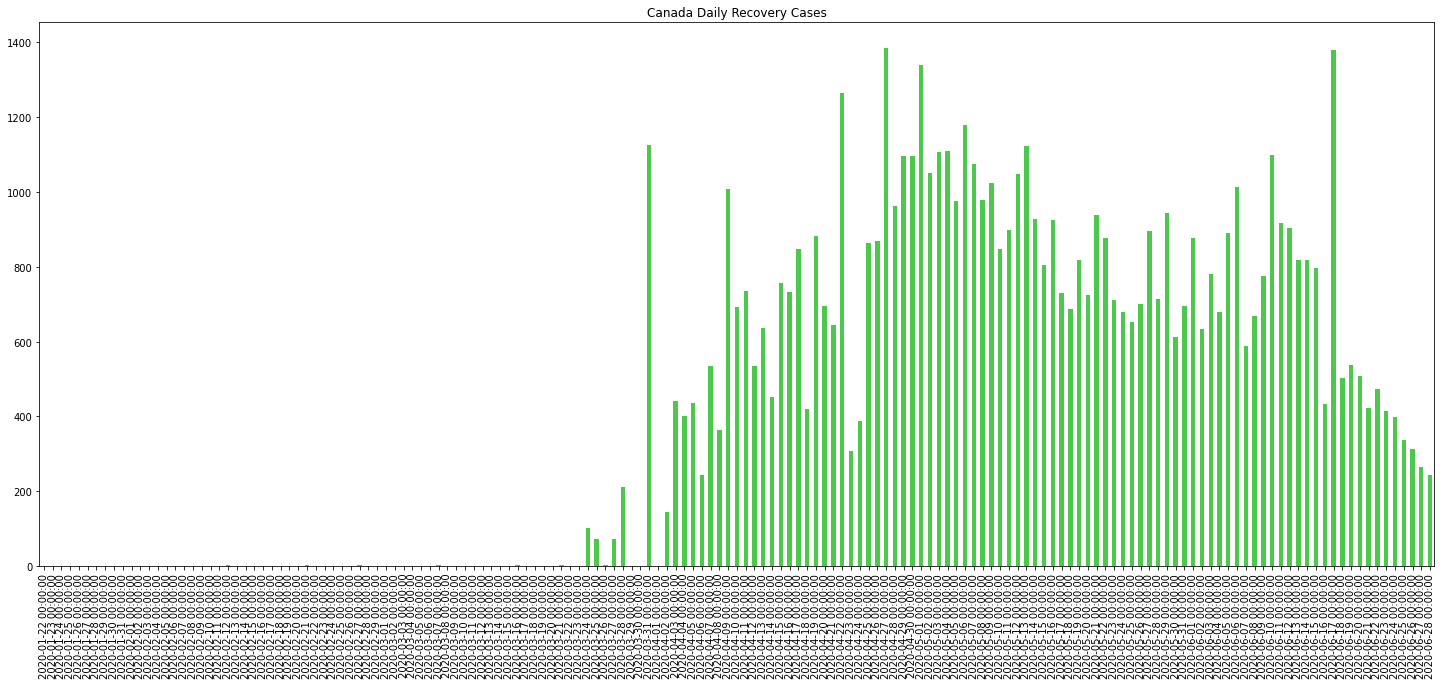

In [ ]:
can_rec_daily=daily_bar_plot(recover_canada, title="Canada Daily Recovery Cases", c=(0,0.7,0,0.7))

In [ ]:
death_canada=df_death[df_death["Country/Region"]=="Canada"]
death_canada, _, _ = sum_regioncase(df_death, "Canada", region_level="country")
death_canada

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6150,6267,6360,6466,6534,6655,6753,6876,6982,7063,7159,7374,7404,7478,7579,7717,7778,7850,7877,7910,7970,8038,8071,8125,8183,8218,8228,8271,8312,8361,8408,8466,8482,8494,8512,8544,8567,8571,8576,8582


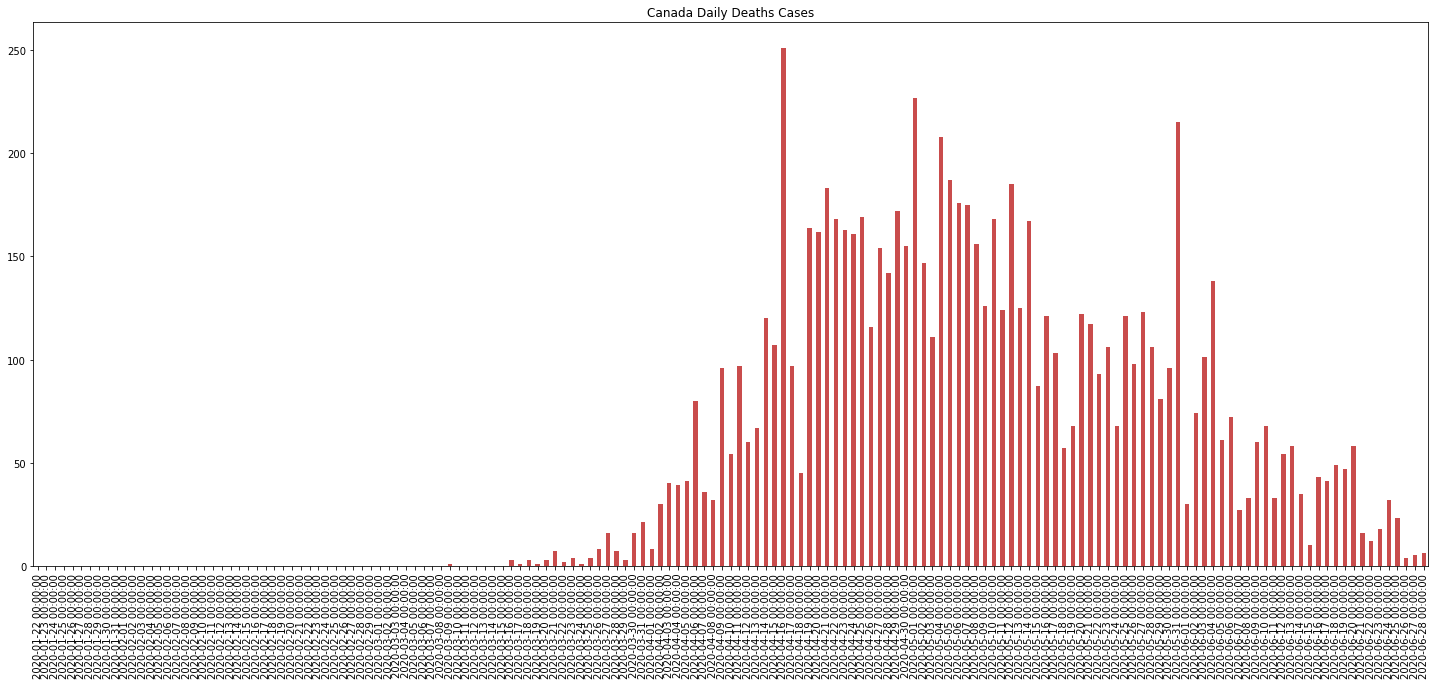

In [ ]:
can_death_daily=daily_bar_plot(death_canada, title="Canada Daily Deaths Cases", c=(0.7,0,0,0.7))

In [ ]:
can_death_daily.iloc[:,110:]

,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,2020-05-16 00:00:00,2020-05-17 00:00:00,2020-05-18 00:00:00,2020-05-19 00:00:00,2020-05-20 00:00:00,2020-05-21 00:00:00,2020-05-22 00:00:00,2020-05-23 00:00:00,2020-05-24 00:00:00,2020-05-25 00:00:00,2020-05-26 00:00:00,2020-05-27 00:00:00,2020-05-28 00:00:00,2020-05-29 00:00:00,2020-05-30 00:00:00,2020-05-31 00:00:00,2020-06-01 00:00:00,2020-06-02 00:00:00,2020-06-03 00:00:00,2020-06-04 00:00:00,2020-06-05 00:00:00,2020-06-06 00:00:00,2020-06-07 00:00:00,2020-06-08 00:00:00,2020-06-09 00:00:00,2020-06-10 00:00:00,2020-06-11 00:00:00,2020-06-12 00:00:00,2020-06-13 00:00:00,2020-06-14 00:00:00,2020-06-15 00:00:00,2020-06-16 00:00:00,2020-06-17 00:00:00,2020-06-18 00:00:00,2020-06-19 00:00:00,2020-06-20 00:00:00,2020-06-21 00:00:00,2020-06-22 00:00:00,2020-06-23 00:00:00,2020-06-24 00:00:00,2020-06-25 00:00:00,2020-06-26 00:00:00,2020-06-27 00:00:00,2020-06-28 00:00:00
0,124,185,125,167,87,121,103,57,68,122,117,93,106,68,121,98,123,106,81,96,215,30,74,101,138,61,72,27,33,60,68,33,54,58,35,10,43,41,49,47,58,16,12,18,32,23,4,5,6


In [ ]:
can_daily=pd.concat([can_conf_daily, can_death_daily, can_rec_daily], axis= 0)
can_daily.index=pd.Series(["Confirmed", "Death", "Recover"])
can_daily

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28
Confirmed,0,0,0,0,1,0,1,0,0,2,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,2,1,6,4,...,1082,1167,1205,1204,955,1013,971,899,987,933,772,798,809,672,681,628,678,528,703,601,462,479,439,436,448,361,359,324,404,386,437,448,316,340,349,320,376,166,249,315
Death,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,122,117,93,106,68,121,98,123,106,81,96,215,30,74,101,138,61,72,27,33,60,68,33,54,58,35,10,43,41,49,47,58,16,12,18,32,23,4,5,6
Recover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,3,0,0,0,...,724,938,877,710,680,653,701,896,713,944,612,696,878,634,781,678,890,1013,588,668,774,1098,916,903,817,817,798,433,1381,502,536,508,423,472,414,398,336,313,263,244


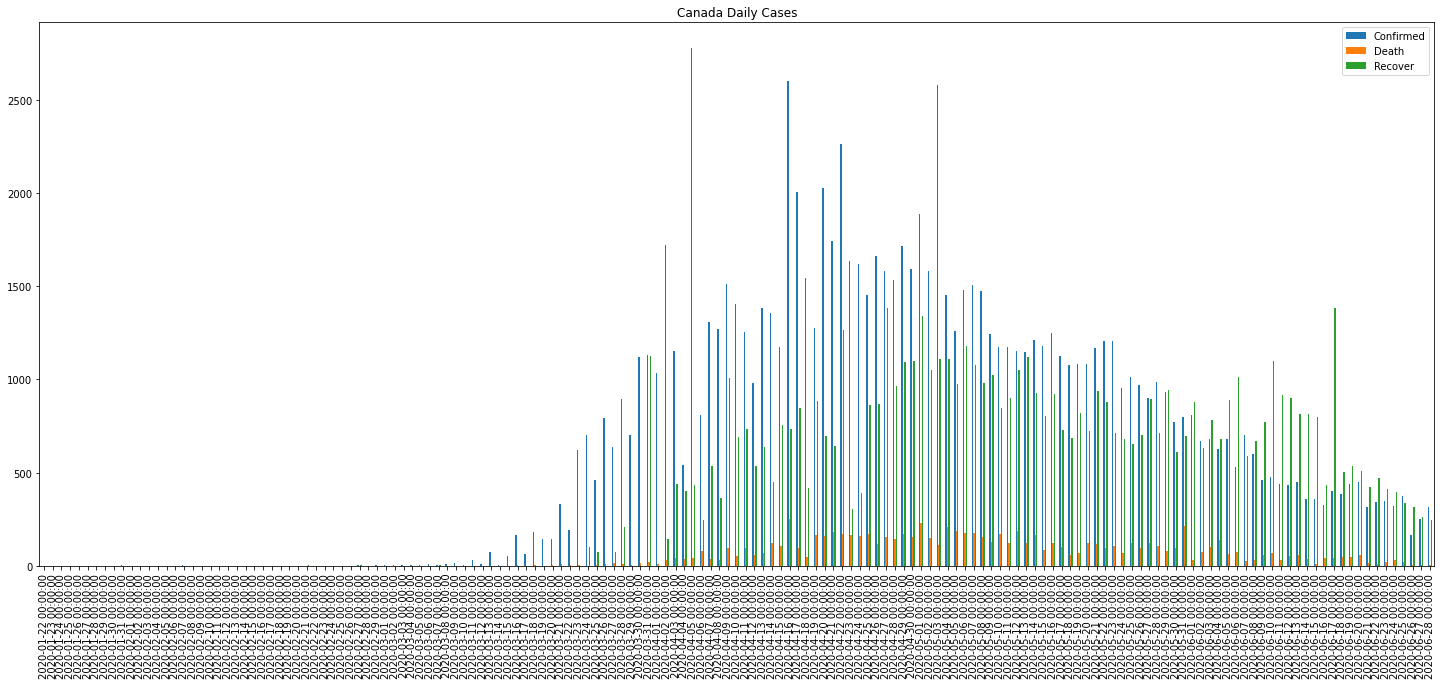

In [ ]:
can_daily.T.plot.bar(title="Canada Daily Cases", figsize=(25,10), legend=True)

## Barh Plot

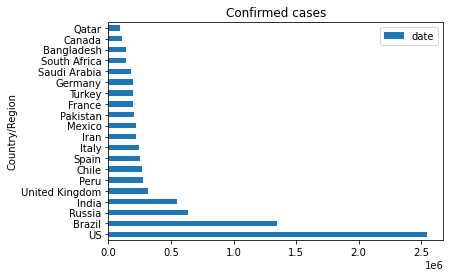

In [ ]:
world_conf = barh_plot(df_conf, title="Confirmed cases", country=True)

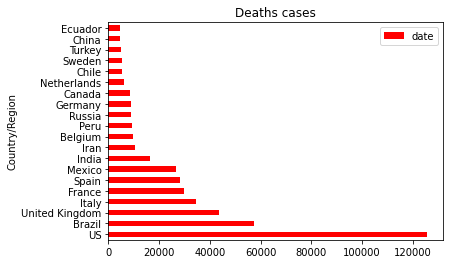

In [ ]:
world_deaths = barh_plot(df_death, title="Deaths cases", country=True, c="red")

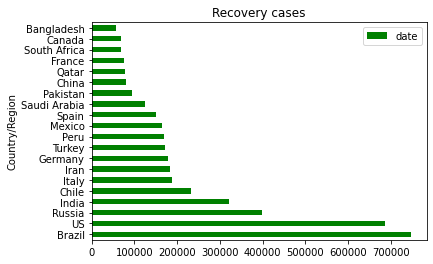

In [ ]:
world_rec = barh_plot(df_recover, title="Recovery cases", country=True, c="green")

### Canada

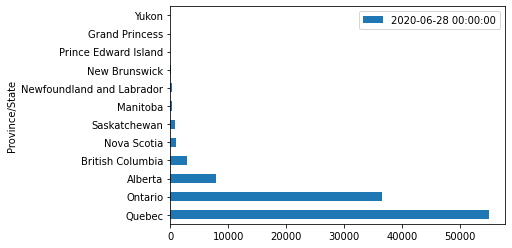

In [ ]:
df_canada=df_conf[df_conf["Country/Region"]=="Canada"]
df_canada=df_canada.drop(df_canada.index[[11,12]])
confirmed=df_canada.iloc[:,[0,-1]]
confirmed=confirmed.sort_values(confirmed.columns[-1], ascending=False)
confirmed_can=confirmed.set_index("Province/State")
ax = confirmed_can.plot.barh()

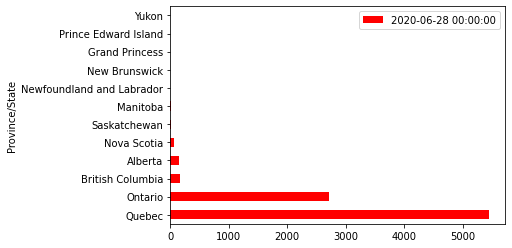

In [ ]:
df_canada=df_death[df_death["Country/Region"]=="Canada"]
df_canada=df_canada.drop(df_canada.index[[11,12]])
death=df_canada.iloc[:,[0,-1]]
death=death.sort_values(death.columns[-1], ascending=False)
death_can=death.set_index("Province/State")
ax = death_can.plot.barh(color='red')

## Pie

### Canada Pie Charts

In [ ]:
# !pip install plotly

In [ ]:
import plotly.express as px

In [ ]:
pie_plot(confirmed, stage="Confirmed", title="Canada Confirmed")

In [ ]:
pie_plot(death, stage="Deaths", title="Canada Deaths")

### Worldwide Pie Charts

In [ ]:
world_conf

,date
Country/Region,
US,2548996
Brazil,1344143
Russia,633563
India,548318
United Kingdom,312640
Peru,279419
Chile,271982
Spain,248770
Italy,240310


In [ ]:
pie_plot(world_conf, stage="Confirmed", title="World Confirmed", inplace=True)

In [ ]:
pie_plot(world_deaths, stage="Deaths", title="World Deaths", inplace=True)

In [ ]:
pie_plot(world_rec, stage="Recovered", title="World Recovered", inplace=True)

## Line Charts

In [ ]:
df_worldclass=worldclass_dataframe(df_conf)
death_worldclass = worldclass_dataframe(df_death)
recover_worldclass=worldclass_dataframe(df_recover)

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



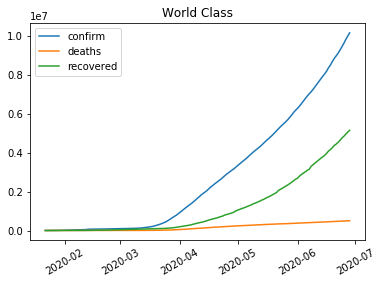

In [ ]:
plt.plot(df_worldclass.loc[0])
plt.plot(death_worldclass.loc[0])
plt.plot(recover_worldclass.loc[0])
plt.xticks(rotation=30)
plt.legend('best', labels=["confirm","deaths","recovered"])
plt.title("World Class")
plt.show()

### Canada

In [ ]:
df_canada, _, _=sum_regioncase(df_conf, "Canada", region_level="county")
death_canada, _, _=sum_regioncase(df_death, "Canada", region_level="county")
recover_canada, _, _=sum_regioncase(df_recover, "Canada", region_level="county")

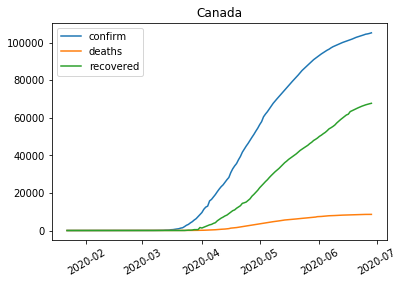

In [ ]:
plt.plot(df_canada.loc[0])
plt.plot(death_canada.loc[0])
plt.plot(recover_canada.loc[0])
plt.xticks(rotation=30)
plt.legend('Upper Left', labels=["confirm","deaths","recovered"])
plt.title("Canada")
plt.show()

### China

In [ ]:
df_china, _, _=sum_regioncase(df_conf, "China", region_level="county")
death_china, _, _=sum_regioncase(df_death, "China",region_level="county")
recover_china, _, _=sum_regioncase(df_recover, "China", region_level="county")

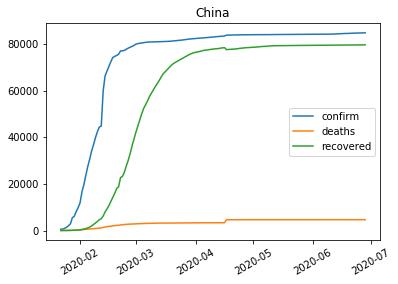

In [ ]:
plt.plot(df_china.loc[0])
plt.plot(death_china.loc[0])
plt.plot(recover_china.loc[0])
plt.xticks(rotation=30)
plt.legend('Upper Left', labels=["confirm","deaths","recovered"])
plt.title("China")
plt.show()

In [ ]:
df_outchina, _, _=sum_regioncase(df_conf, "China", region_level="outside China")
death_outchina, _, _=sum_regioncase(df_death, "China",region_level="outside China")
recover_outchina, _, _=sum_regioncase(df_recover, "China", region_level="outside China")

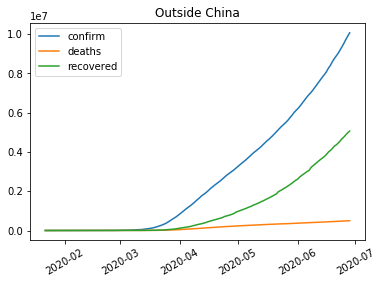

In [ ]:
plt.plot(df_outchina.loc[0])
plt.plot(death_outchina.loc[0])
plt.plot(recover_outchina.loc[0])
plt.xticks(rotation=30)
plt.legend('best', labels=["confirm","deaths","recovered"])
plt.title("Outside China")
plt.show()

### Hubei Province, China

In [ ]:
df_hubei=df_conf[df_conf["Province/State"]=="Hubei"].iloc[:,4:]
df_hubei

,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,...,2020-06-19 00:00:00,2020-06-20 00:00:00,2020-06-21 00:00:00,2020-06-22 00:00:00,2020-06-23 00:00:00,2020-06-24 00:00:00,2020-06-25 00:00:00,2020-06-26 00:00:00,2020-06-27 00:00:00,2020-06-28 00:00:00
62,444,444,549,761,1058,1423,3554,3554,4903,5806,...,68135,68135,68135,68135,68135,68135,68135,68135,68135,68135


In [ ]:
df_hubei, _, _=sum_regioncase(df_conf, "Hubei", region_level="province")
death_hubei, _, _=sum_regioncase(df_death, "Hubei",region_level="province")
recover_hubei, _, _=sum_regioncase(df_recover, "Hubei", region_level="province")

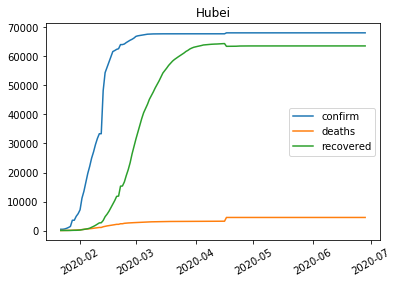

In [ ]:
plt.plot(df_hubei.loc[0])
plt.plot(death_hubei.loc[0])
plt.plot(recover_hubei.loc[0])
plt.xticks(rotation=30)
plt.legend('Upper Left', labels=["confirm","deaths","recovered"])
plt.title("Hubei")
plt.show()

### Italy

In [ ]:
df_italy, _, _=sum_regioncase(df_conf, "Italy", region_level="county")
death_italy, _, _=sum_regioncase(df_death, "Italy",region_level="county")
recover_italy, _, _=sum_regioncase(df_recover, "Italy", region_level="county")

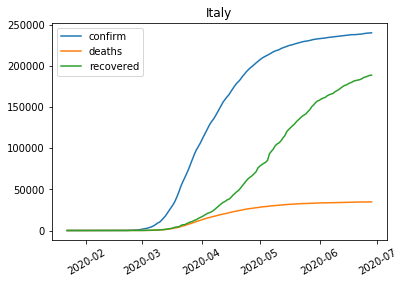

In [ ]:
plt.plot(df_italy.loc[0])
plt.plot(death_italy.loc[0])
plt.plot(recover_italy.loc[0])
plt.xticks(rotation=30)
plt.legend('Upper Left', labels=["confirm","deaths","recovered"])
plt.title("Italy")
plt.show()